In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from skimage.transform import resize
from skimage.io import imread
from skimage import color

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [3]:
def grayscale(a):
    return a.reshape(a.shape[0], 3, 32, 32).mean(1).reshape(a.shape[0], -1)

In [4]:
def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

In [5]:
def read_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    for i in range(1, 6):
        filename = '{}/data_batch_{}'.format(directory, i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels


In [6]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [7]:
class SimpleCNNModel(object):
    
    def __init__(self):
        self.W1 = tf.Variable(tf.random.normal([5, 5, 1, 64], dtype=tf.float32), dtype=tf.float32) # first convo layer with 64 filters size 5x5, one band greyscale, image input size 24x24
        self.b1 = tf.Variable(tf.random.normal([64], dtype=tf.float32), dtype=tf.float32) # biases for first convo layer
        self.W2 = tf.Variable(tf.random.normal([5, 5, 64, 64], dtype=tf.float32), dtype=tf.float32) # second convo layer with 64 filters size 5x5, run on the 64 outputs of first layer, image input size 12x12
        self.b2 = tf.Variable(tf.random.normal([64], dtype=tf.float32), dtype=tf.float32) # biases for the second convo layer
        self.W3 = tf.Variable(tf.random.normal([6*6*64, 1024], dtype=tf.float32), dtype=tf.float32) # fully connected layer taking output of convo layer which are 64 image inputs size 6x6 and mapping to 32x32 original image 
        self.b3 = tf.Variable(tf.random.normal([1024], dtype=tf.float32), dtype=tf.float32) # biases for fully connected layer
        self.W_out = tf.Variable(tf.random.normal([1024, len(names)], dtype=tf.float32), dtype=tf.float32) # output weights for final layer of actual labels, 1024 features  mapped to 10 labels one hot encoded - used for hlf correlations
        self.b_out = tf.Variable(tf.random.normal([len(names)], dtype=tf.float32), dtype=tf.float32) # biases for output labels  
        
    def __call__(self, x):
        x_reshaped = tf.cast(tf.reshape(x, shape=[-1, 24, 24, 1]), dtype=tf.float32)
        conv_out1 = self.__conv_layer(x_reshaped, self.W1, self.b1)
        maxpool_out1 = self.__maxpool_layer(conv_out1)
        norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        conv_out2 = self.__conv_layer(norm1, self.W2, self.b2)
        norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        maxpool_out2 = self.__maxpool_layer(norm2)
        maxpool_reshaped = tf.reshape(maxpool_out2, [-1, self.W3.get_shape().as_list()[0]])
        local = tf.add(tf.matmul(maxpool_reshaped, self.W3), self.b3)
        local_out = tf.nn.relu(local)
        out = tf.add(tf.matmul(local_out, self.W_out), self.b_out)
        return out
    
    def __conv_layer(self, x, W, b):
        conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
        conv_with_b = tf.nn.bias_add(conv, b)
        conv_out = tf.nn.relu(conv_with_b)
        return conv_out

    def __maxpool_layer(self, conv, k=2):
        return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')



In [8]:
def loss(inputs, outputs):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=inputs, labels=outputs))   

In [9]:
def train_step(model, inputs, outputs):
        with tf.GradientTape() as t:
            current_loss = loss(model(inputs), outputs)

        grads = t.gradient(current_loss, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3, model.W_out, model.b_out])
        optimizer.apply_gradients(zip(grads,[model.W1, model.b1, model.W2, model.b2, model.W3, model.b3, model.W_out, model.b_out]))
        return current_loss

In [10]:
def correct_predictions(model, inputs, outputs):
    return tf.equal(tf.argmax(model(inputs), 1), tf.argmax(outputs, 1))

In [11]:
def accuracy(correct_pred):
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
names, data, labels = read_data('../../data/cifar-10-batches-py')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)


In [13]:
model = SimpleCNNModel()

In [14]:
epochs=1000

In [15]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, 
                          W1=model.W1,
                          b1=model.b1,
                          W2=model.W2,
                          b2=model.b2,
                          W3=model.W3,
                          b3=model.b3,
                          W_out=model.W_out,
                          b_out=model.b_out)
manager = tf.train.CheckpointManager(ckpt, '../../models/cifar10-cnn-tf1n-'+str(epochs)+'epochs.ckpt', max_to_keep=3)

In [16]:
onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
batch_size = len(data) // 200
print('batch size', batch_size)
for j in tqdm(range(0, epochs)):
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i+batch_size, :]
        batch_onehot_vals = onehot_labels[i:i+batch_size, :]
        err = train_step(model, batch_data, batch_onehot_vals)

    ckpt.step.assign_add(1)

    correct_preds = correct_predictions(model, batch_data, batch_onehot_vals)
    accuracy_val = accuracy(correct_preds).numpy()
    print("epoch {} loss {:1.2f} accuracy {:1.2f}".format(j, err.numpy(), accuracy_val))


    if int(ckpt.step) % 100 == 0:
        save_path = manager.save()
        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
        print("loss {:1.2f}".format(err.numpy()))


batch size 250


epoch 0 loss 3016.66 accuracy 0.25
epoch 1 loss 1775.77 accuracy 0.26
epoch 2 loss 1293.44 accuracy 0.28
epoch 3 loss 951.66 accuracy 0.32
epoch 4 loss 751.95 accuracy 0.36
epoch 5 loss 630.18 accuracy 0.36
epoch 6 loss 549.84 accuracy 0.38
epoch 7 loss 474.12 accuracy 0.39
epoch 8 loss 429.94 accuracy 0.39
epoch 9 loss 383.40 accuracy 0.41
epoch 10 loss 354.64 accuracy 0.40
epoch 11 loss 310.20 accuracy 0.37
epoch 12 loss 290.56 accuracy 0.38
epoch 13 loss 271.55 accuracy 0.38
epoch 14 loss 251.55 accuracy 0.40
epoch 15 loss 248.67 accuracy 0.34
epoch 16 loss 223.37 accuracy 0.36
epoch 17 loss 228.26 accuracy 0.36
epoch 18 loss 223.21 accuracy 0.39
epoch 19 loss 197.26 accuracy 0.44
epoch 20 loss 195.59 accuracy 0.38
epoch 21 loss 173.23 accuracy 0.37
epoch 22 loss 168.61 accuracy 0.38
epoch 23 loss 213.49 accuracy 0.37
epoch 24 loss 142.50 accuracy 0.42
epoch 25 loss 155.94 accuracy 0.41
epoch 26 loss 124.34 accuracy 0.37
epoch 27 loss 132.81 accuracy 0.41
epoch 28 loss 161.62 accura

epoch 231 loss 24.59 accuracy 0.60
epoch 232 loss 22.22 accuracy 0.59
epoch 233 loss 19.42 accuracy 0.66
epoch 234 loss 25.90 accuracy 0.58
epoch 235 loss 21.96 accuracy 0.68
epoch 236 loss 26.33 accuracy 0.62
epoch 237 loss 18.77 accuracy 0.59
epoch 238 loss 17.82 accuracy 0.68
epoch 239 loss 20.30 accuracy 0.63
epoch 240 loss 15.26 accuracy 0.66
epoch 241 loss 16.61 accuracy 0.63
epoch 242 loss 16.02 accuracy 0.64
epoch 243 loss 32.64 accuracy 0.60
epoch 244 loss 17.77 accuracy 0.62
epoch 245 loss 15.41 accuracy 0.65
epoch 246 loss 13.82 accuracy 0.64
epoch 247 loss 15.51 accuracy 0.60
epoch 248 loss 11.59 accuracy 0.64
epoch 249 loss 23.67 accuracy 0.57
epoch 250 loss 15.76 accuracy 0.67
epoch 251 loss 36.04 accuracy 0.51
epoch 252 loss 22.16 accuracy 0.67
epoch 253 loss 14.97 accuracy 0.67
epoch 254 loss 20.58 accuracy 0.64
epoch 255 loss 13.09 accuracy 0.63
epoch 256 loss 22.75 accuracy 0.60
epoch 257 loss 15.32 accuracy 0.65
epoch 258 loss 22.50 accuracy 0.64
epoch 259 loss 16.37

epoch 462 loss 11.76 accuracy 0.78
epoch 463 loss 14.78 accuracy 0.78
epoch 464 loss 17.51 accuracy 0.72
epoch 465 loss 15.81 accuracy 0.68
epoch 466 loss 13.52 accuracy 0.68
epoch 467 loss 10.80 accuracy 0.70
epoch 468 loss 13.01 accuracy 0.74
epoch 469 loss 7.79 accuracy 0.71
epoch 470 loss 8.26 accuracy 0.71
epoch 471 loss 5.82 accuracy 0.70
epoch 472 loss 5.69 accuracy 0.72
epoch 473 loss 8.34 accuracy 0.72
epoch 474 loss 6.15 accuracy 0.78
epoch 475 loss 7.26 accuracy 0.75
epoch 476 loss 8.80 accuracy 0.72
epoch 477 loss 7.58 accuracy 0.77
epoch 478 loss 9.20 accuracy 0.75
epoch 479 loss 9.66 accuracy 0.79
epoch 480 loss 17.62 accuracy 0.72
epoch 481 loss 10.91 accuracy 0.78
epoch 482 loss 13.35 accuracy 0.76
epoch 483 loss 14.07 accuracy 0.78
epoch 484 loss 14.22 accuracy 0.74
epoch 485 loss 17.30 accuracy 0.76
epoch 486 loss 13.32 accuracy 0.71
epoch 487 loss 11.12 accuracy 0.69
epoch 488 loss 12.45 accuracy 0.70
epoch 489 loss 10.17 accuracy 0.71
epoch 490 loss 11.37 accuracy 0

epoch 696 loss 8.84 accuracy 0.88
epoch 697 loss 6.52 accuracy 0.90
epoch 698 loss 6.27 accuracy 0.90
Saved checkpoint for step 700: ../../models/cifar10-cnn-tf1n-1000epochs.ckpt/ckpt-7
loss 6.27
epoch 699 loss 6.93 accuracy 0.88
epoch 700 loss 6.20 accuracy 0.86
epoch 701 loss 8.26 accuracy 0.86
epoch 702 loss 10.01 accuracy 0.82
epoch 703 loss 3.72 accuracy 0.82
epoch 704 loss 4.67 accuracy 0.91
epoch 705 loss 5.04 accuracy 0.93
epoch 706 loss 4.18 accuracy 0.95
epoch 707 loss 4.14 accuracy 0.94
epoch 708 loss 4.21 accuracy 0.92
epoch 709 loss 4.99 accuracy 0.86
epoch 710 loss 4.06 accuracy 0.87
epoch 711 loss 4.07 accuracy 0.88
epoch 712 loss 1.98 accuracy 0.94
epoch 713 loss 2.82 accuracy 0.94
epoch 714 loss 3.28 accuracy 0.95
epoch 715 loss 3.44 accuracy 0.94
epoch 716 loss 4.73 accuracy 0.92
epoch 717 loss 5.07 accuracy 0.91
epoch 718 loss 5.15 accuracy 0.90
epoch 719 loss 4.13 accuracy 0.92
epoch 720 loss 2.90 accuracy 0.93
epoch 721 loss 4.32 accuracy 0.92
epoch 722 loss 5.46 a

epoch 929 loss 1.31 accuracy 0.99
epoch 930 loss 0.05 accuracy 1.00
epoch 931 loss 0.64 accuracy 1.00
epoch 932 loss 1.44 accuracy 0.99
epoch 933 loss 0.76 accuracy 0.98
epoch 934 loss 0.25 accuracy 1.00
epoch 935 loss 0.21 accuracy 1.00
epoch 936 loss 1.17 accuracy 0.99
epoch 937 loss 0.05 accuracy 1.00
epoch 938 loss 0.23 accuracy 0.99
epoch 939 loss 1.89 accuracy 0.99
epoch 940 loss 1.35 accuracy 1.00
epoch 941 loss 1.08 accuracy 0.99
epoch 942 loss 0.07 accuracy 1.00
epoch 943 loss 1.58 accuracy 0.99
epoch 944 loss 0.54 accuracy 1.00
epoch 945 loss 0.64 accuracy 1.00
epoch 946 loss 2.02 accuracy 0.99
epoch 947 loss 0.98 accuracy 1.00
epoch 948 loss 0.38 accuracy 0.99
epoch 949 loss 0.88 accuracy 1.00
epoch 950 loss 0.52 accuracy 1.00
epoch 951 loss 0.00 accuracy 0.99
epoch 952 loss 0.18 accuracy 0.99
epoch 953 loss 0.63 accuracy 0.99
epoch 954 loss 0.53 accuracy 0.99
epoch 955 loss 0.65 accuracy 0.98
epoch 956 loss 0.06 accuracy 1.00
epoch 957 loss 0.86 accuracy 1.00
epoch 958 loss

In [19]:
def predict(img_data):
    save_path = "../../models/cifar10-cnn-tf1n-"+str(epochs)+"epochs.ckpt/ckpt-10"
    ckpt.restore(save_path).assert_consumed()
    print("Model restored.")
    model_x_out = model(img_data)
    class_num = np.argmax(model_x_out, axis=1)[0]
    class_name = names[class_num]
    return (class_num, class_name) 

In [20]:
class_num, class_name = predict(data[3])
print('Class Num', class_num)
print('Class', class_name)

Model restored.
Class Num 4
Class deer


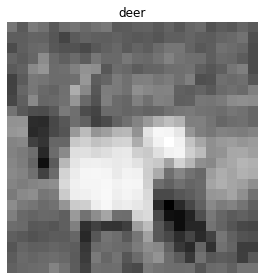

In [21]:
plt.figure()
plt.title(class_name)
img = np.reshape(data[3, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [22]:
# test out on test images
def read_test_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    
    filename = '{}/test_batch'.format(directory)
    batch_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, batch_data['data']))
        labels = np.hstack((labels, batch_data['labels']))
    else:
        data = batch_data['data']
        labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels

In [23]:
test_names, test_data, test_labels = read_test_data('../../data/cifar-10-batches-py')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(10000, 3072) (10000,)


In [24]:
test_class_num, test_class_name = predict(test_data[4])
print('Test Class Num', test_class_num)
print('Test Class Name', test_class_name)
print('Actual Class Label', test_labels[4])

Model restored.
Test Class Num 6
Test Class Name frog
Actual Class Label 6


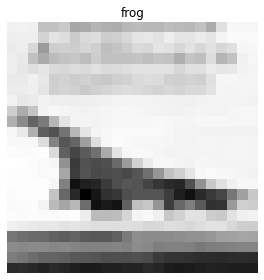

In [25]:
plt.figure()
plt.title(test_class_name)
img = np.reshape(test_data[3, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [27]:
def get_test_accuracy(test_data, test_names, test_labels):
    save_path = "../../models/cifar10-cnn-tf1n-"+str(epochs)+"epochs.ckpt/ckpt-10"
    ckpt.restore(save_path).assert_consumed()
    print("Model restored.")
    model_x_out = model(test_data)
        
    onehot_test_labels = tf.one_hot(test_labels, len(test_names), on_value=1., off_value=0., axis=-1)
    test_correct_pred = tf.equal(tf.argmax(model_x_out, 1), tf.argmax(onehot_test_labels, 1))
    test_accuracy = tf.reduce_mean(tf.cast(test_correct_pred, tf.float32))

    print('Test accuracy %f' % (test_accuracy.numpy()))  
    predictions = tf.argmax(model_x_out, 1).numpy()
    return (predictions, tf.cast(test_correct_pred, tf.float32).numpy(), onehot_test_labels.numpy())

    
predict_vals, test_correct_preds, onehot_test_lbls = get_test_accuracy(test_data, test_names, test_labels)
print(predict_vals)
print(predict_vals.shape)
print(test_correct_preds)
print(test_correct_preds.shape)
print(onehot_test_lbls.shape)

Model restored.
Test accuracy 0.575100
[8 8 8 ... 5 4 7]
(10000,)
[0. 1. 1. ... 1. 0. 1.]
(10000,)
(10000, 10)


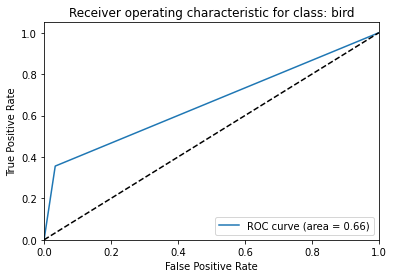

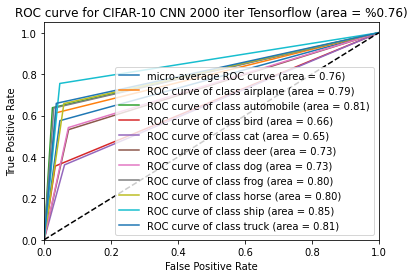

In [28]:
outcome_test = label_binarize(test_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
predictions_test = label_binarize(predict_vals, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = outcome_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(outcome_test[:, i], predictions_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(outcome_test.ravel(), predictions_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for class: '+test_names[2])
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(test_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
roc_mean = np.mean(np.fromiter(roc_auc.values(), dtype=float))
plt.title('ROC curve for CIFAR-10 CNN 2000 iter Tensorflow (area = %{0:0.2f})'.format(roc_mean))
plt.legend(loc="lower right")
plt.show()

In [29]:
def predict_img_url(url):
    image = color.rgb2gray(imread(url))
    print(image.shape)
    plt.figure()
    plt.title('URL from Internet')
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off')
    plt.tight_layout()
    new_size = 24,24
    image = resize(image, new_size, anti_aliasing=True)
    print(image.shape)
    images = np.expand_dims(image, axis=0)
    print(images.shape)
    im_data = images.astype(np.float32)
    print(im_data.shape)
    prediction = predict(im_data[0])
    print(prediction)
    print("Cropped to 24x24")
    plt.figure()
    plt.title('Pic from Internet (24x24): '+str(prediction[1])) # prediction format is (class num,label)
    plt.imshow(images[0], cmap='Greys_r')
    plt.axis('off')
    plt.tight_layout()
    return prediction


(480, 720)
(24, 24)
(1, 24, 24)
(1, 24, 24)
Model restored.
(3, 'cat')
Cropped to 24x24
(619, 1100)
(24, 24)
(1, 24, 24)
(1, 24, 24)
Model restored.
(3, 'cat')
Cropped to 24x24
(667, 1000)
(24, 24)
(1, 24, 24)
(1, 24, 24)
Model restored.
(8, 'ship')
Cropped to 24x24
(2000, 3008)
(24, 24)
(1, 24, 24)
(1, 24, 24)
Model restored.
(0, 'airplane')
Cropped to 24x24
(1800, 2400)
(24, 24)
(1, 24, 24)
(1, 24, 24)
Model restored.
(3, 'cat')
Cropped to 24x24
(487, 646)
(24, 24)
(1, 24, 24)
(1, 24, 24)
Model restored.
(3, 'cat')
Cropped to 24x24
(495, 660)
(24, 24)
(1, 24, 24)
(1, 24, 24)
Model restored.
(3, 'cat')
Cropped to 24x24
(1162, 1742)
(24, 24)
(1, 24, 24)
(1, 24, 24)
Model restored.
(3, 'cat')
Cropped to 24x24
[(3, 'cat'), (3, 'cat'), (8, 'ship'), (0, 'airplane'), (3, 'cat'), (3, 'cat'), (3, 'cat'), (3, 'cat')]


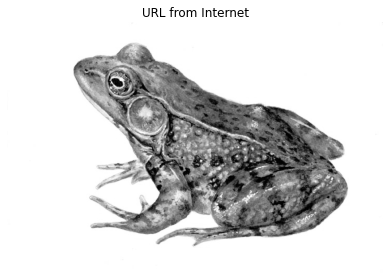

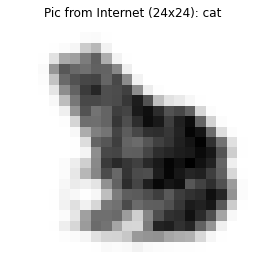

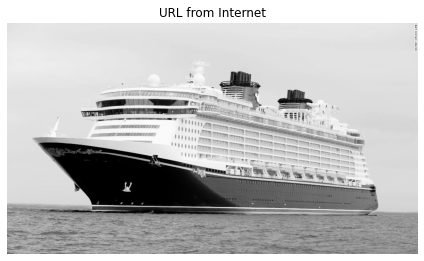

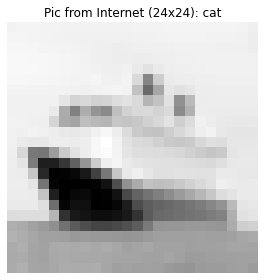

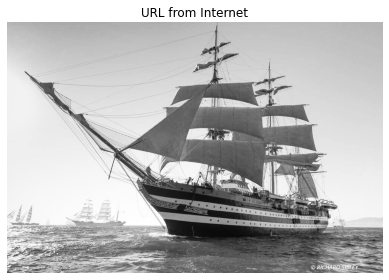

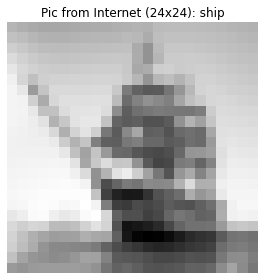

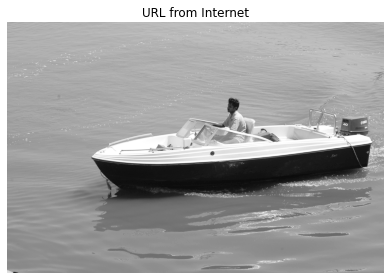

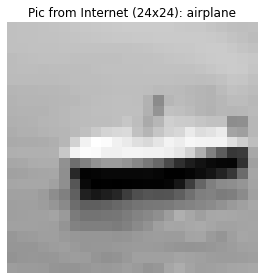

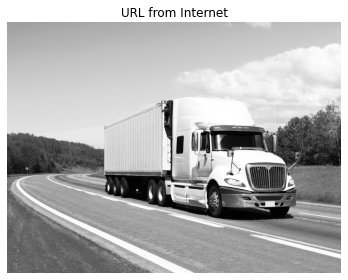

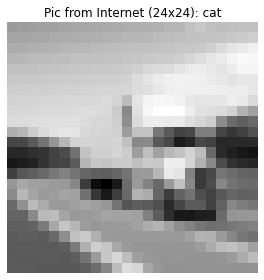

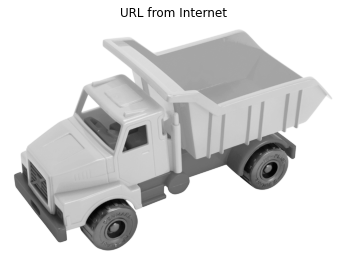

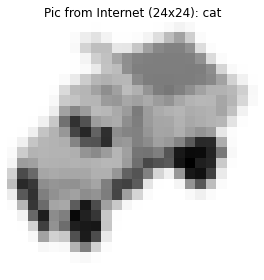

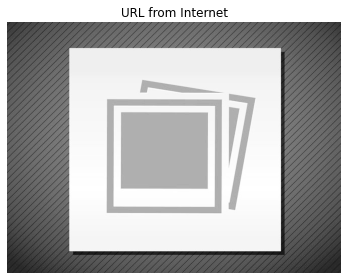

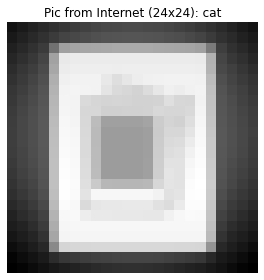

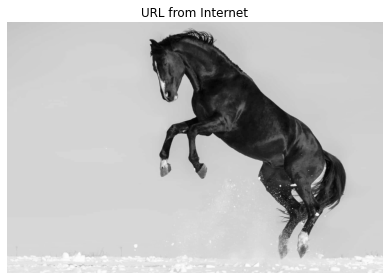

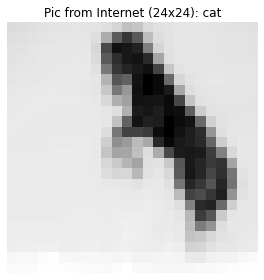

In [30]:
predict_urls = [
    'http://www.torontozoo.com/adoptapond/guide_images/Green%20Frog.jpg', #frog
    'https://cdn.cnn.com/cnnnext/dam/assets/160205192735-01-best-cruise-ships-disney-dream-super-169.jpg', #ship
    'https://www.sailboston.com/wp-content/uploads/2016/11/amerigo-vespucci.jpg', #ship
    'https://upload.wikimedia.org/wikipedia/commons/d/d9/Motorboat_at_Kankaria_lake.JPG', #ship
    'https://media.wired.com/photos/5b9c3d5e7d9d332cf364ad66/master/pass/AV-Trucks-187479297.jpg', #truck
    'https://images.schoolspecialty.com/images/1581176_ecommfullsize.jpg', #truck
    'https://img.purch.com/w/660/aHR0cDovL3d3dy5saXZlc2NpZW5jZS5jb20vaW1hZ2VzL2kvMDAwLzEwNC84MTkvb3JpZ2luYWwvY3V0ZS1raXR0ZW4uanBn', # cat
    'https://thehorse.com/wp-content/uploads/2017/01/iStock-510488648.jpg' #horse
]

predicted_labels = []
for url in predict_urls:
    pred = predict_img_url(url)
    predicted_labels.append(pred)

print(predicted_labels)